In [1]:
import math
import random

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from kan import KAN as PyKAN
from torch import nn, optim
from tqdm import tqdm

from efficient_kan.kan import KAN as EffKAN

plt.rcParams.update({'font.size': 18})
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Torque target Stochastic Regression

In this notebook we're going to train a `PyKAN`, an `EfficientKAN`, and a `MLP` to learn a function that maps each set of input features to its own probability distribution.

We assume that the underlying process has many small, independent disturbances. Thus, Leveraging the Central limit theorem, we can say that the error between the model's prediction and **the actual observed value is likely to be normal**.

## Load dataset

In [2]:
USE_SYNTHETIC_DATASET = False  # Generated with 2-Synthetic_Dataset.ipynb

if USE_SYNTHETIC_DATASET:
    df = pd.read_csv('../dataset/synthetic.csv')
    df_normalized = (df - df.mean()) / df.std()
    df_x_normalized = df_normalized.drop(columns=['label'])
    df_y_normalized = df_normalized['label']
else:
    df_x = pd.read_csv('../dataset/X_train.csv').drop(columns=['id'])
    df_y = pd.read_csv('../dataset/y_train.csv').drop(columns=['id', 'faulty'])
    df_y['trq_target'] = df_x['trq_measured'] / (df_y['trq_margin'] / 100 + 1)
    df_x_normalized = (df_x - df_x.mean()) / df_x.std()
    df_y_normalized = (df_y['trq_target'] - df_y['trq_target'].mean()) / df_y['trq_target'].std()
    df_x_normalized.drop(columns=['trq_measured'], inplace=True)

dataset_x = torch.tensor(df_x_normalized.values, dtype=torch.float32, device=device)
dataset_y = torch.tensor(df_y_normalized.values, dtype=torch.float32, device=device).unsqueeze(1)
assert (dataset_x.shape[0] == dataset_y.shape[0])

In [3]:
dataset_size = dataset_x.shape[0]
random_indices = np.random.choice(dataset_size, size=dataset_size, replace=False)

# Train set = 10% Data set
train_x = dataset_x[random_indices[:int(dataset_size * 0.1)]]
train_y = dataset_y[random_indices[:int(dataset_size * 0.1)]]

# Valid set = 10% Data set
valid_x = dataset_x[random_indices[int(dataset_size * 0.1):int(dataset_size * 0.2)]]
valid_y = dataset_y[random_indices[int(dataset_size * 0.1):int(dataset_size * 0.2)]]

# Test set = 20% Data set
test_x = dataset_x[random_indices[int(dataset_size * 0.2):int(dataset_size * 0.4)]]
test_y = dataset_y[random_indices[int(dataset_size * 0.2):int(dataset_size * 0.4)]]

## Define the train() and test() functions

In [4]:
def train(model, optimizer, epochs, batch_size=8192):
    criterion = nn.GaussianNLLLoss(reduction='mean')
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.97)
    train_losses = []
    validation_losses = []
    for epoch in range(epochs):
        epoch_train_losses = []
        epoch_validation_losses = []

        # Training
        model.train()
        with tqdm(range(train_x.size(0) // batch_size)) as pbar:
            for i in pbar:
                x = train_x[i * batch_size:(i + 1) * batch_size]
                y = train_y[i * batch_size:(i + 1) * batch_size]
                optimizer.zero_grad()
                mu, log_var = model(x)
                loss = criterion(mu, y.squeeze(), torch.exp(log_var))
                loss.backward()
                epoch_train_losses.append(loss.item())
                optimizer.step(closure=lambda: loss)
                pbar.set_postfix(loss=loss.item(), lr=optimizer.param_groups[0]['lr'])
        scheduler.step()

        # Validation
        model.eval()
        for i in range(valid_x.size(0) // batch_size):
            x = valid_x[i * batch_size:(i + 1) * batch_size]
            y = valid_y[i * batch_size:(i + 1) * batch_size]
            mu, log_var = model(x)
            loss = criterion(mu, y.squeeze(), torch.exp(log_var))
            loss.backward()
            epoch_validation_losses.append(loss.item())

        train_losses.append(np.mean(epoch_train_losses))
        validation_losses.append(np.mean(epoch_validation_losses))

    # Plot losses
    plt.figure(figsize=(24, 8))
    plt.plot(train_losses, label='Training loss')
    plt.plot(validation_losses, label='Validation loss')
    plt.legend()
    plt.show()

In [5]:
def test(model) -> float:
    model.eval()
    criterion = nn.GaussianNLLLoss(reduction='mean')
    test_losses = []
    for i in range(valid_x.size(0) // 8192):
        x = test_x[i * 8192:(i + 1) * 8192]
        y = test_y[i * 8192:(i + 1) * 8192]
        mu, log_var = model(x)
        loss = criterion(mu, y.squeeze(), torch.exp(log_var))
        loss.backward()
        test_losses.append(loss.item())
    return sum(test_losses) / len(test_losses)

## Train the PyKAN

In [6]:
class Py_KAN(nn.Module):
    def __init__(self, layers, grid_size=8):
        super(Py_KAN, self).__init__()
        self.model = PyKAN(width=layers, grid=grid_size, k=3, device=device)

    def forward(self, x):
        x = self.model(x)
        mu = x[:, 0]
        var = x[:, 1]
        return mu, var

In [22]:
pyKAN = Py_KAN(layers=[[6, 0], [1, 0], [2, 0]], grid_size=2)

checkpoint directory created: ./model
saving model version 0.0


In [ ]:
pyKAN.model = PyKAN.loadckpt('models/torque_target_stochastic_pykan.pt')

100%|██████████| 9/9 [00:00<00:00, 32.10it/s, loss=-3.22, lr=0.0045]


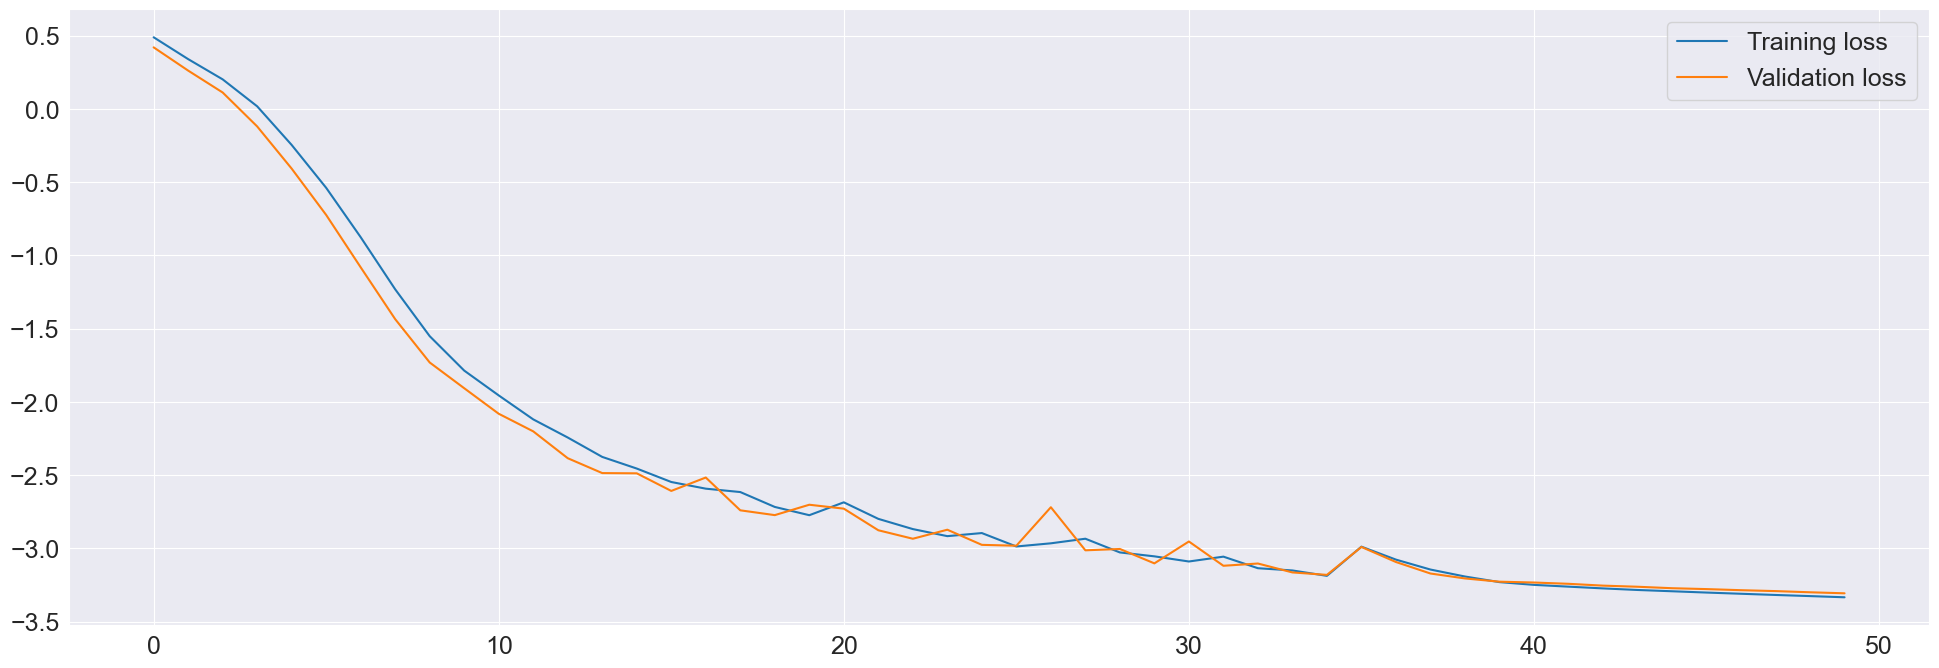

In [13]:
train(pyKAN, optim.Adam(pyKAN.parameters(), lr=0.02), epochs=50)

In [24]:
test(pyKAN)

-3.3271606498294406

In [16]:
pyKAN.model.saveckpt('models/torque_target_stochastic_pykan.pt')

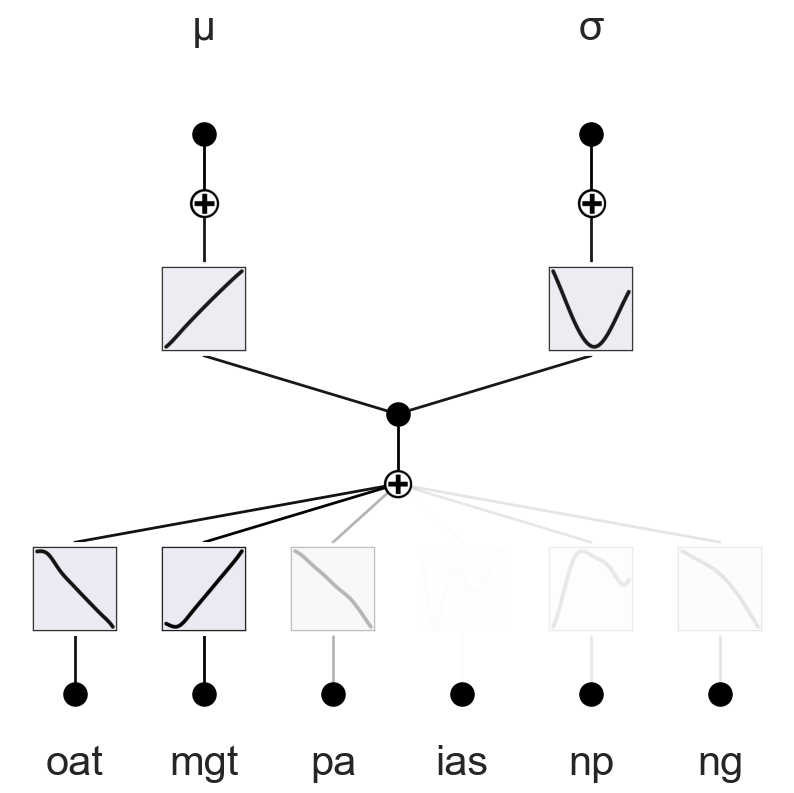

In [25]:
pyKAN.model.plot(scale=1, in_vars=['oat', 'mgt', 'pa', 'ias', 'np', 'ng'], out_vars=['μ', 'σ'], varscale=0.75)

## Train the EfficientKAN

In [27]:
class Efficient_KAN(nn.Module):
    def __init__(self, layers, grid_size=8):
        super(Efficient_KAN, self).__init__()
        self.model = EffKAN(layers,
                            grid_size=grid_size,
                            # grid_eps=1,
                            # scale_base=0,
                            # sp_trainable=False,
                            # sb_trainable=False,
                            # enable_standalone_scale_spline=False
                            ).to(device)

    def forward(self, x):
        # x = x / dataset_size * 2 - 1
        # x = x.view(-1, self.layers[0])
        x = self.model(x)
        mu = x[:, 0]
        var = x[:, 1]  #F.softplus(x[:, 1]) + 1e-6
        return mu, var

In [28]:
efficientKAN = Efficient_KAN(layers=[6, 1, 2], grid_size=2)

In [30]:
efficientKAN.model.load_state_dict(torch.load('models/torque_target_stochastic_effkan.pt', weights_only=True))

<All keys matched successfully>

100%|██████████| 9/9 [00:00<00:00, 106.10it/s, loss=-3.2, lr=0.000214]


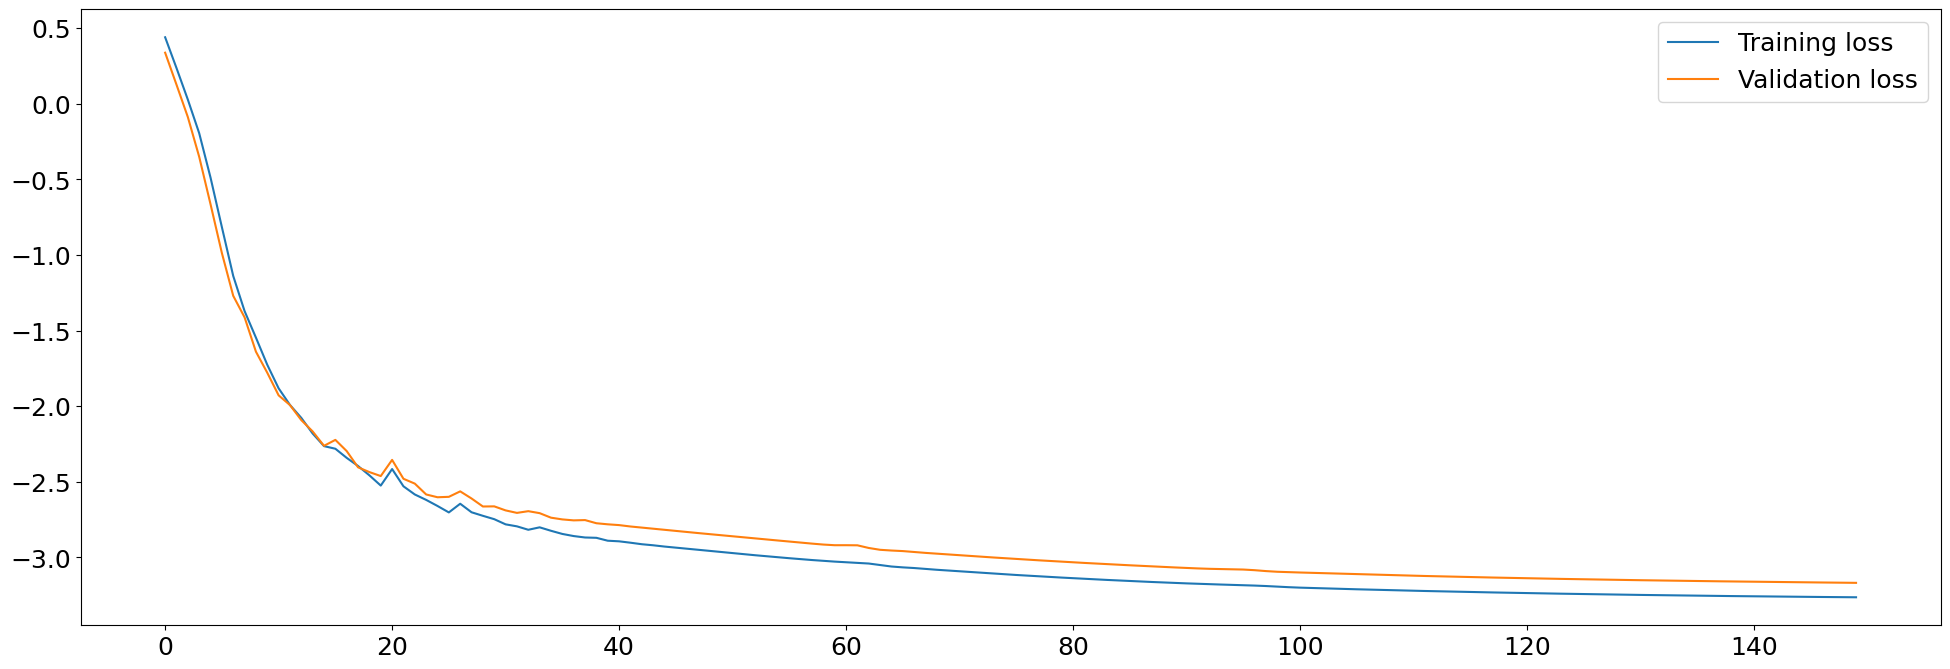

In [682]:
train(efficientKAN, optim.Adam(efficientKAN.parameters(), lr=0.02), epochs=150)

In [31]:
test(efficientKAN)

-3.2451777924557734

In [688]:
torch.save(efficientKAN.model.state_dict(), 'models/torque_target_stochastic_effkan.pt')

In [32]:
def plot_spline(model: EffKAN, x_range, scale=1, resolution=50):
    base_colors = [(1, 0, 0), (0, 1, 0), (0, 0, 1)]

    def random_color():
        return random.random(), random.random(), random.random()

    colors = [base_colors[x] if x < len(base_colors) else random_color()
              for x in range(max(map(lambda l: l.in_features, model.layers)))]
    for layer in reversed(model.layers):
        fig, axes = plt.subplots(1, layer.in_features * layer.out_features,
                                 figsize=(2 * scale * layer.in_features * layer.out_features, 2 * scale))
        for i in range(layer.in_features):
            for j in range(layer.out_features):
                x_vals = torch.linspace(x_range[0], x_range[1], resolution)

                # B-Splines
                if len(layer.grid) <= j:
                    continue
                grid = layer.grid[j, :].unsqueeze(0).to(device)  # The knots
                x = x_vals.unsqueeze(-1).unsqueeze(-1).to(device)
                bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)  # Determine the interval for each point
                for k in range(1, layer.spline_order + 1):
                    bases = (
                                    (x - grid[:, : -(k + 1)])
                                    / (grid[:, k:-1] - grid[:, : -(k + 1)])
                                    * bases[:, :, :-1]
                            ) + (
                                    (grid[:, k + 1:] - x)
                                    / (grid[:, k + 1:] - grid[:, 1:(-k)])
                                    * bases[:, :, 1:]
                            )

                y_vals = F.linear(bases.squeeze(), layer.scaled_spline_weight[j, i]).to(device)
                y_vals += (layer.base_activation(x_vals).to(device) * layer.base_weight[j, i].to(device))

                alpha = math.tanh(abs(3 * layer.spline_scaler.view(layer.out_features, -1)[j, i].item()))
                if type(axes) is np.ndarray:
                    axes[i * layer.out_features + j].plot(x_vals.cpu().detach().numpy(), y_vals.cpu().detach().numpy(),
                                                          alpha=alpha, color=colors[i])
                    axes[i * layer.out_features + j].grid(True)
                else:
                    axes.plot(x_vals, y_vals, alpha=alpha, color=colors[i])
                    axes.grid(True)

    # plt.tight_layout()
    plt.show()

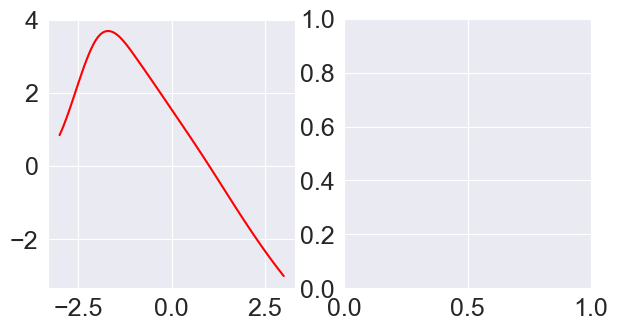

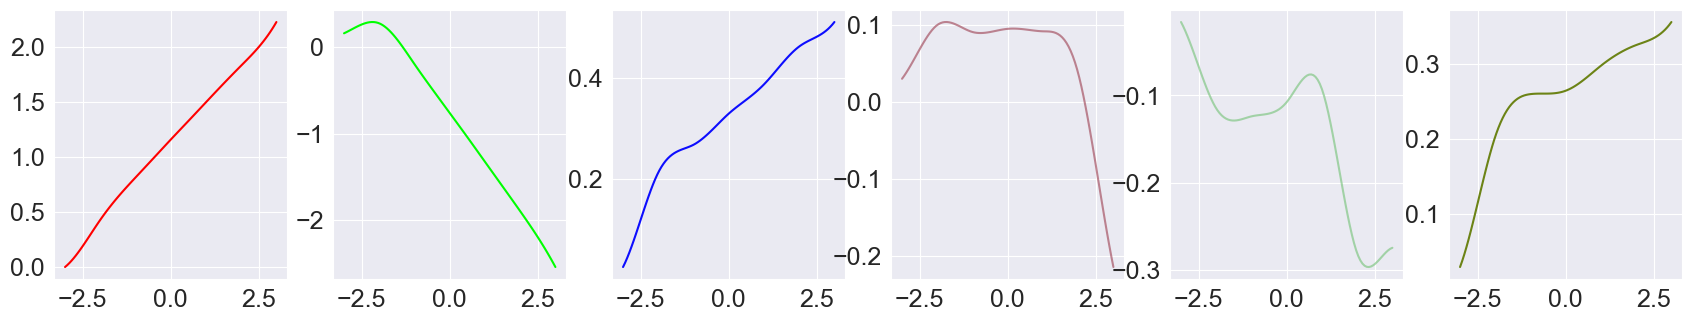

In [40]:
plot_spline(efficientKAN.model, [-3, 3], scale=1.75, resolution=100)

## Train the MLP

In [41]:
class MLP(nn.Module):
    def __init__(self, layers_size, deterministic=False):
        super(MLP, self).__init__()
        self.layers_size = layers_size
        layers = []
        for i in range(len(layers_size) - 1):
            layers.append(nn.Linear(layers_size[i], layers_size[i + 1]))
            if i < len(layers_size) - 2:  # Add activation for all layers except the last one
                layers.append(nn.Sigmoid())
        self.model = nn.Sequential(*layers)
        self.deterministic = deterministic

    def forward(self, x):
        output = self.model(x)
        if self.deterministic:
            return output
        else:
            mu = output[:, 0]
            var = output[:, 1]
            return mu, var

In [42]:
mlp = MLP([6, 256, 256, 2], deterministic=False).to(device)

In [43]:
mlp.load_state_dict(torch.load('models/torque_target_stochastic_mlp.pt', weights_only=True))

<All keys matched successfully>

100%|██████████| 9/9 [00:00<00:00, 178.22it/s, loss=-5.26, lr=1.11e-6]


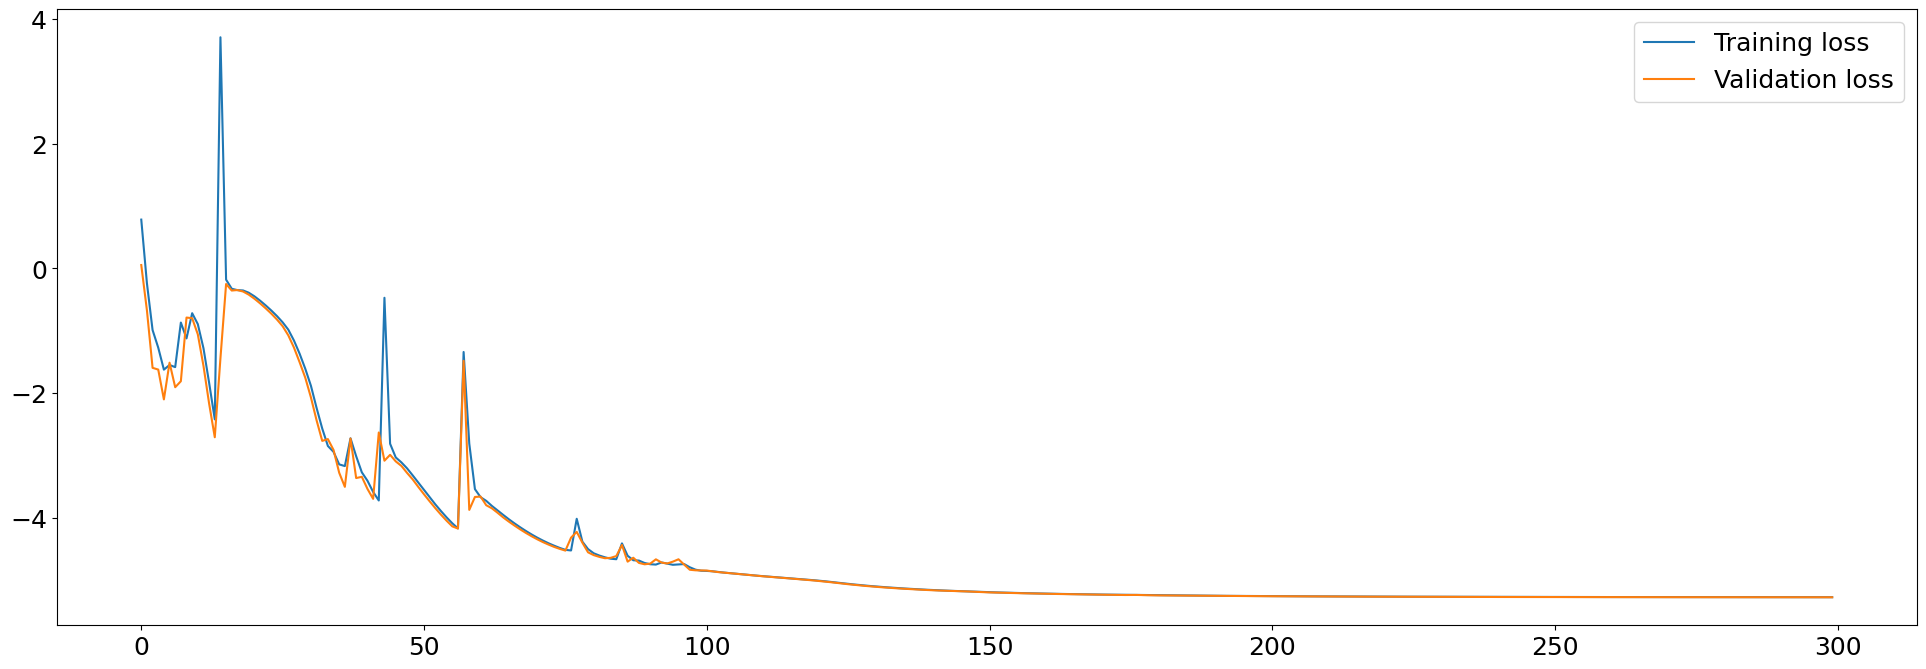

In [696]:
train(mlp, optim.Adam(mlp.parameters(), lr=.01), epochs=300)

In [698]:
torch.save(mlp.state_dict(), 'models/torque_target_stochastic_mlp.pt')

In [44]:
test(mlp)

-5.265438609653049

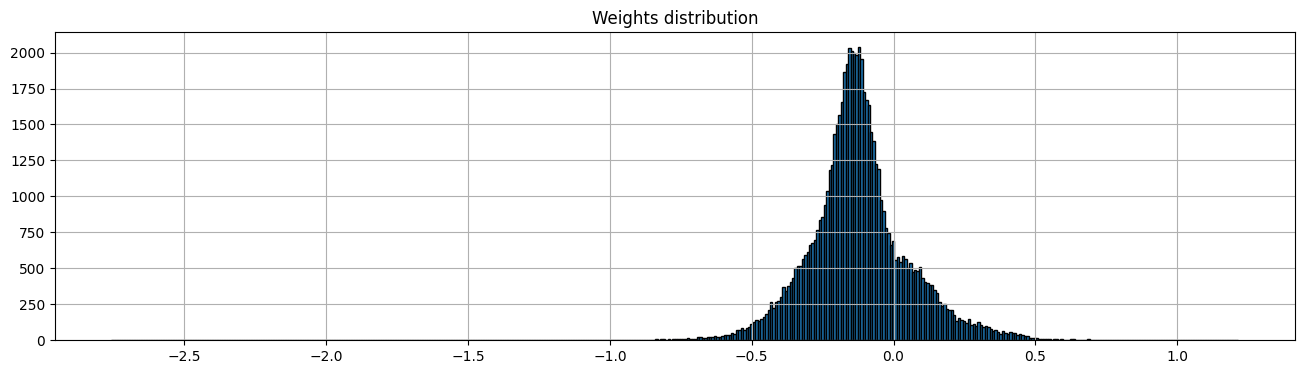

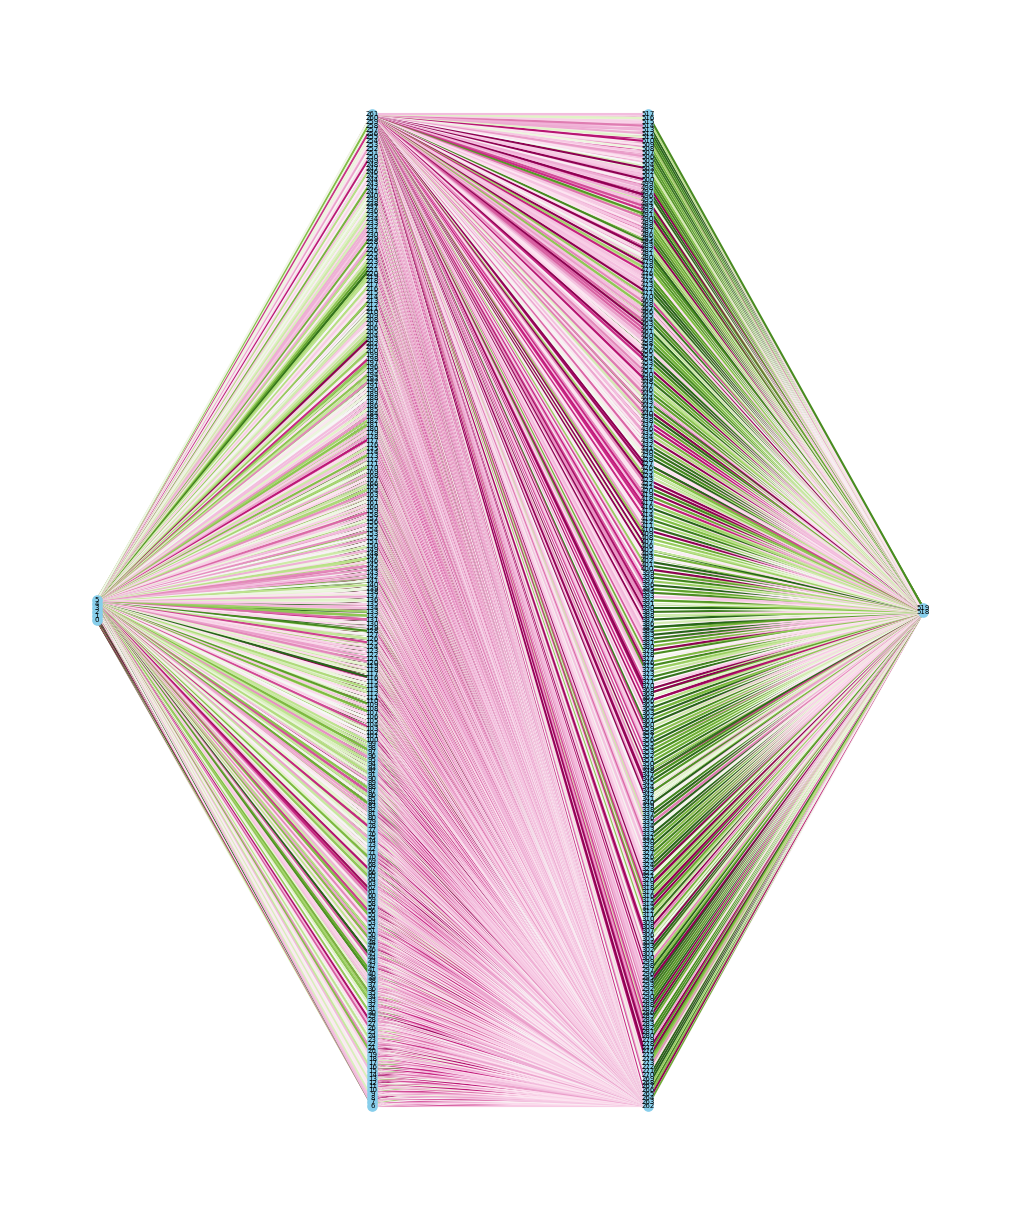

In [610]:
def plot_mlp(net: MLP):
    layers = [net.model[0].in_features]
    linears = list(filter(lambda l: type(l) == torch.nn.modules.linear.Linear, mlp.model))
    for l in linears:
        layers.append(l.out_features)
    # layers = [6, 50, 50, 2]
    G = nx.Graph()
    pos = {}
    node_count = 0
    layer_gap = 5
    node_gap = 1
    max_layer = max(layers)

    for i, layer_size in enumerate(layers):
        delta = max_layer - layer_size
        for j in range(layer_size):
            G.add_node(node_count)
            pos[node_count] = (i * layer_gap, (j + delta // 2) * node_gap)
            if i > 0:
                for k in range(layers[i - 1]):
                    G.add_edge(node_count - layers[i - 1] + k - j, node_count,
                               weight=linears[i - 1].weight[j, k].item())
            node_count += 1

    weights = [G[u][v]['weight'] for u, v in G.edges()]
    plt.figure(1, figsize=(16, 4))
    plt.hist(weights, bins='auto', edgecolor='black')
    plt.grid()
    plt.title('Weights distribution')
    plt.figure(3, figsize=(10, 12))
    nx.draw(G, pos, with_labels=True, node_size=44, node_color="skyblue", edge_cmap=plt.colormaps['PiYG'],
            edge_color=weights, edge_vmin=-0.5, edge_vmax=0.5, font_size=5, width=1.5)
    plt.show()


plot_mlp(mlp)
